# An Introduction to Working with EPA CEMS data

CEMS or <a href='https://www.epa.gov/emc/emc-continuous-emission-monitoring-systems'>**Continusous Emissions Monitoring Systems**</a> are used to track power plant's compliance with EPA emission standards. Among the data are hourly measurements of SO2, CO2, and NOx emissions associated with a given plant. The EPA's <a href='https://www.epa.gov/airmarkets'>Clean Air Markets Division</a> has collected CEMS data stretching back to 1990 and publicized it in their <a href='https://ampd.epa.gov/ampd/'>data portal</a>. Combinging the CEMS data with EIA and FERC data, provides access to greater and more specific information about utilities and generation facilities. This notebook provides a glimpse into the analysis potential of CEMS-EIA data integration.

**NOTE**: This Notebook presuposes access to the parquet files in which the CEMS data is stored.

##### Notebook Contents:
* **<a href='#access'>Accessing CEMS data</a>**
 - <a href='#1subset'>1. Select a subset of raw data using Dask</a>
 - <a href='#2transfer'>2. Transfer desired data to pandas</a>
* **<a href='#manipulating'>Manipulating & Visualizing CEMS data</a>**
 - <a href='#emap'>1. Simple Choropleth</a>
 - <a href='#pcem'>2. Proportional Coordinates Map</a>
 - <a href='#glc'>3. State-to-State Gross Load Comparison</a>
 - <a href=''></a>

# Setup

The following packages enable interaction with the CEMS dataset through pudl.

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard libraries
import logging
import os
import pathlib
import sys

# 3rd party libraries
import geopandas as gpd
#import geoplot as gplt
import dask.dataframe as dd
from dask.distributed import Client
import numpy as np
import pandas as pd
import sqlalchemy as sa
import pyarrow

# Local libraries
import pudl

In [3]:
logger=logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set()
%matplotlib inline

In [5]:
pudl_settings = pudl.workspace.setup.get_defaults()
#display(pudl_settings)

ferc1_engine = sa.create_engine(pudl_settings['ferc1_db'])
#display(ferc1_engine)

pudl_engine = sa.create_engine(pudl_settings['pudl_db'])
#display(pudl_engine)

#pudl_engine.table_names()
pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine, freq='AS') #annual frequency

# Reading in EPA CEMS data
<a id='access'></a>

The CEMS dataset is enormous! It contains hourly operations and emissions data for thousands of power plants between 1995 and 2019.
The full dataset is close to a billion rows and takes up 100 GB of space uncompressed, which means it will not all fit in memory
on your laptop at the same time. [Dask](https://dask.org) is a pandas-like library that provides lots of functionality for dealing
with larger than memory datasets. [This post by Tom Augsperger](https://tomaugspurger.github.io/modern-8-scaling.html) is a nice compact
introduction to working with larger datasets in Pandas / Dask.

One of the main features of Dask is "lazy execution" -- it doesn't read data or do any computation until it has to, or you explicitly tell it to. Instead,
it allows you to build of a series of computational instructions, and then it intelligently looks at those instructions and executes them so as to minimize
memory utilization and/or parallelize the tasks if possible.

For example, you can "read" in the full EPA CEMS dataset almost instantly... but that's because no data has been read off of disk yet. The instructions
for reading off of the disk have been added to the list of things the Dask dataframe will do when you actually as it for a result.

In [6]:
epacems_path = pathlib.Path(pudl_settings["parquet_dir"]) / "epacems"
epacems_dd = dd.read_parquet(epacems_path)

However, some information about the dataframe is available at this point -- including the names of the columns and their data types -- because that
information is stored in the Parquet file metadata:

In [7]:
epacems_dd.dtypes

plant_id_eia                               int32
unitid                                    string
operating_datetime_utc       datetime64[ns, UTC]
operating_time_hours                     float32
gross_load_mw                            float32
steam_load_1000_lbs                      float32
so2_mass_lbs                             float32
so2_mass_measurement_code               category
nox_rate_lbs_mmbtu                       float32
nox_rate_measurement_code               category
nox_mass_lbs                             float32
nox_mass_measurement_code               category
co2_mass_tons                            float32
co2_mass_measurement_code               category
heat_content_mmbtu                       float32
facility_id                                Int32
unit_id_epa                                Int32
year                                    category
state                                   category
dtype: object

If you want to know anything about the contents of the data itself, some data will have to be read in, and some computation performed.
Before any aggregations or calculations or selections have happened, you can ask how many rows there are in the whole parquet dataset,
and it will be returned relatively quickly, since that information is also stored in the metadata. This would behave differently later
on, since after you've told the dataframe to do some computation, you'd be asking for the length of the **result of that computation**
not the original inputs.

In [8]:
%%time
len(epacems_dd)

CPU times: user 25.6 s, sys: 2.12 s, total: 27.8 s
Wall time: 18.7 s


791223000

## Select a subset of EPA CEMS rows
<a id='1subset'></a>

You can point Dask at a large parquet dataset like EPA CEMS and tell it to read in only a subset of the columns, and the select a subset of the rows
based on some criteria of interest. So long as the collection of rows and columns you've specified end up being smaller than the available memory on
you computer, this operation will succeed. However, depending on how fast your disk is, it may still take longer than you would like.


The following statement will tell Dask where the dataset is, and describe a subset of the data that should be returned as a pandas dataframe (only data about
power plants in Colorado, in the year 2018 -- which should be small enough to fit in memory), but it won't actually read the data in yet:

In [9]:
slow_epacems_dd = (
    dd.read_parquet(epacems_path)
    .query("year==2018")
    .query("state=='CO'")
)

If we're satisfied that this is the data we want, then we can go ahead and ask Dask to read it in and give us a pandas dataframe back.
This will alloweus to search through more than 50 GB of data on disk and select only the small subset that we are interested in without
blowing up our memory usage. However, it will still take a long time -- maybe 5 minutes on a laptop with a fast SSD (uncomment it if you
want to actually give this a try...):

In [10]:
#%%time
#slow_epacems_df = slow_epacems_dd.compute()

## Filter using Parquet partitions

To make operations like this faster and easier, we have pre-partitioned the EPA CEMS Parquet dataset by `state` and `year` -- there's a separate parquet file
that contains each state's data for each year, in a directory structure that many tools for working with Parquet files understand. This means you can tell Dask
that there are only certain files it needs to look in for the data you're interested in. Rather than scanning through 50 GB of data across 1300 different files,
it can just read data from the single file that contains the 2018 data for Colorado. On a computer with a fast SSD, this should takes about a fraction of a second:

In [11]:
%%time
epacems_dd = dd.read_parquet(
    epacems_path,
    filters=[[("state", "=", "CO"), ("year", "=", 2018)]],
)
epacems_df = epacems_dd.compute()
epacems_df.sample(10)

/home/zane/miniconda3/envs/pudl-dev/lib/python3.8/site-packages/dask/dataframe/io/parquet/arrow.py:680: UserWarning: Filtering with gather_statistics=False. Only partition columns will be filtered correctly.
  warnings.warn(


CPU times: user 328 ms, sys: 28.4 ms, total: 357 ms
Wall time: 372 ms


plant_id_eia unitid    operating_datetime_utc  operating_time_hours  \
228149          8219      3 2018-05-26 12:00:00+00:00                   0.0   
505566         55504     L1 2018-10-09 13:00:00+00:00                   0.0   
146725         56445  CT-01 2018-03-03 20:00:00+00:00                   0.0   
452048         55453      5 2018-09-23 15:00:00+00:00                   0.0   
487976          8219      2 2018-10-20 15:00:00+00:00                   0.0   
422086           525     H1 2018-09-05 05:00:00+00:00                   1.0   
335760         50707   S002 2018-07-24 07:00:00+00:00                   1.0   
538776          6761      F 2018-11-26 07:00:00+00:00                   0.0   
278045          6761      F 2018-06-25 12:00:00+00:00                   0.0   
477261          6021     C3 2018-10-08 04:00:00+00:00                   1.0   

        gross_load_mw  steam_load_1000_lbs  so2_mass_lbs  \
228149            0.0                  NaN           NaN   
505566            0.0                  NaN           NaN   
146725            0.0                  NaN           NaN   
452048            0.0                  NaN           NaN   
487976            0.0                  NaN           NaN   
422086          155.0                  NaN    223.199997   
335760           26.0                  NaN      0.133000   
538776            0.0                  NaN           NaN   
278045            0.0                  NaN           NaN   
477261          468.0                  NaN    554.700012   

       so2_mass_measurement_code  nox_rate_lbs_mmbtu  \
228149                       NaN                 NaN   
505566                       NaN                 NaN   
146725                       NaN                 NaN   
452048                       NaN                 NaN   
487976                       NaN                 NaN   
422086                  Measured               0.041   
335760                  Measured               0.087   
538776                       NaN                 NaN   
278045                       NaN                 NaN   
477261                  Measured               0.268   

       nox_rate_measurement_code  nox_mass_lbs nox_mass_measurement_code  \
228149                       NaN           NaN                       NaN   
505566                       NaN           NaN                       NaN   
146725                       NaN           NaN                       NaN   
452048                       NaN           NaN                       NaN   
487976                       NaN           NaN                       NaN   
422086                  Measured     69.392998                Calculated   
335760                  Measured     19.261999                Calculated   
538776                       NaN           NaN                       NaN   
278045                       NaN           NaN                       NaN   
477261                  Measured   1219.614014                Calculated   

        co2_mass_tons co2_mass_measurement_code  heat_content_mmbtu  \
228149            NaN                       NaN            0.000000   
505566            NaN                       NaN            0.000000   
146725            NaN                       NaN            0.000000   
452048            NaN                       NaN            0.000000   
487976            NaN                       NaN            0.000000   
422086     173.699997                  Measured         1692.500000   
335760      13.200000                  Measured          221.399994   
538776            NaN                       NaN            0.000000   
278045            NaN                       NaN            0.000000   
477261     477.299988                  Measured         4550.799805   

        facility_id  unit_id_epa  year state  
228149         1074         3468  2018    CO  
505566         1524         4903  2018    CO  
146725         8152        89736  2018    CO  
452048         1493         4794  2018    CO  
487976

### A Partition Filter Shortcut
Unfortunately, the nested list of lists of boolean predicates used to specify the filters (known as
[disjunctive normal form](https://en.wikipedia.org/wiki/Disjunctive_normal_form) is a little unwieldy, so we have some
helper functions that can construct them for you. `pudl.output.epacems.year_state_filter()` will give you a filter that
selects the data for all combinations of the years and states you specify:

In [12]:
demo_filter = pudl.output.epacems.year_state_filter(years=[2018, 2019], states=["CO", "CA"])
demo_filter

[[('year', '=', 2018), ('state', '=', 'CO')],
 [('year', '=', 2018), ('state', '=', 'CA')],
 [('year', '=', 2019), ('state', '=', 'CO')],
 [('year', '=', 2019), ('state', '=', 'CA')]]

In [13]:
%%time
epacems_dd = dd.read_parquet(
    epacems_path,
    filters=demo_filter
)
epacems_df = epacems_dd.compute()
epacems_df.sample(10)

/home/zane/miniconda3/envs/pudl-dev/lib/python3.8/site-packages/dask/dataframe/io/parquet/arrow.py:680: UserWarning: Filtering with gather_statistics=False. Only partition columns will be filtered correctly.
  warnings.warn(


CPU times: user 3.76 s, sys: 871 ms, total: 4.63 s
Wall time: 3.43 s


plant_id_eia unitid    operating_datetime_utc  operating_time_hours  \
1746323         55985   CTG1 2018-10-30 19:00:00+00:00                   0.0   
215111            399     12 2018-02-22 07:00:00+00:00                   0.0   
1660093          7987     01 2019-10-15 21:00:00+00:00                   0.0   
1468929           389    2-2 2018-09-13 17:00:00+00:00                   0.0   
1010112         56135      2 2019-06-26 08:00:00+00:00                   0.0   
2006887          7315      1 2019-12-14 15:00:00+00:00                   1.0   
887061            302      6 2019-06-29 05:00:00+00:00                   0.0   
1410031         57483   GT-1 2019-08-16 15:00:00+00:00                   0.0   
708227          57978    CT1 2018-04-20 19:00:00+00:00                   0.0   
894219            330      5 2019-06-27 11:00:00+00:00                   0.0   

         gross_load_mw  steam_load_1000_lbs  so2_mass_lbs  \
1746323            0.0                  NaN           NaN   
215111             0.0                  NaN           NaN   
1660093            0.0                  NaN           NaN   
1468929            0.0                  NaN           NaN   
1010112            0.0                  NaN           NaN   
2006887           36.0                  NaN         0.203   
887061             0.0                  NaN           NaN   
1410031            0.0                  NaN           NaN   
708227             0.0                  NaN           NaN   
894219             0.0                  NaN           NaN   

        so2_mass_measurement_code  nox_rate_lbs_mmbtu  \
1746323                       NaN                 NaN   
215111                        NaN                 NaN   
1660093                       NaN                 NaN   
1468929                       NaN                 NaN   
1010112                       NaN                 NaN   
2006887                  Measured                0.01   
887061                        NaN                 NaN   
1410031                       NaN                 NaN   
708227                        NaN                 NaN   
894219                        NaN                 NaN   

        nox_rate_measurement_code  nox_mass_lbs nox_mass_measurement_code  \
1746323                       NaN           NaN                       NaN   
215111                        NaN           NaN                       NaN   
1660093                       NaN           NaN                       NaN   
1468929                       NaN           NaN                       NaN   
1010112                       NaN           NaN                       NaN   
2006887                  Measured         3.377                Calculated   
887061                        NaN           NaN                       NaN   
1410031                       NaN           NaN                       NaN   
708227                        NaN           NaN                       NaN   
894219                        NaN           NaN                       NaN   

         co2_mass_tons co2_mass_measurement_code  heat_content_mmbtu  \
1746323            NaN                       NaN            0.000000   
215111             NaN                       NaN            0.000000   
1660093            NaN                       NaN            0.000000   
1468929            NaN                       NaN            0.000000   
1010112            NaN                       NaN            0.000000   
2006887           20.1                  Measured          337.700012   
887061             NaN                       NaN            0.000000   
1410031            NaN                       NaN            0.000000   
708227             NaN                       NaN            0.000000   
894219             NaN                       NaN            0.000000   

         facility_id  unit_id_epa  year state  
1746323         8009        89252  2018    CA  
215111            71          264  2018    CA  
1660093         7514         9888  2019    

## Limiting columns

Often you will only be interested in a certain subset of the columns stored in a parquet dataset.
Parquet files are organized internally to make it very efficient to only select certain columns, and the `read_parquet()` method makes this easy.
Say you're only interested in power outputs, fuel consumed, and CO2 emissions, but not traditional air pollutants:

In [14]:
%%time
ghg_cols = [
    "state",
    "year",
    "operating_datetime_utc",
    "plant_id_eia",
    "facility_id",
    "unit_id_epa",
    "unitid",
    "operating_time_hours",
    "gross_load_mw",
    "heat_content_mmbtu",
    "co2_mass_tons",
]
epacems_dd = dd.read_parquet(
    epacems_path,
    filters=demo_filter,
    columns=ghg_cols,
)
epacems_df = epacems_dd.compute()
epacems_df.sample(10)

/home/zane/miniconda3/envs/pudl-dev/lib/python3.8/site-packages/dask/dataframe/io/parquet/arrow.py:680: UserWarning: Filtering with gather_statistics=False. Only partition columns will be filtered correctly.
  warnings.warn(


CPU times: user 2.93 s, sys: 528 ms, total: 3.46 s
Wall time: 2.8 s


state  year    operating_datetime_utc  plant_id_eia  facility_id  \
429506     CO  2018 2018-09-14 09:00:00+00:00          6112          821   
17828      CA  2019 2019-01-31 04:00:00+00:00           350           63   
1423122    CA  2019 2019-09-07 02:00:00+00:00           260           47   
698701     CA  2019 2019-04-13 21:00:00+00:00         57555         8323   
6993       CO  2019 2019-01-13 16:00:00+00:00           492           83   
2026746    CA  2018 2018-12-28 02:00:00+00:00           400           72   
406279     CO  2018 2018-08-17 14:00:00+00:00         55835         7584   
1327583    CA  2018 2018-08-05 07:00:00+00:00         10405         8337   
323082     CO  2019 2019-07-23 01:00:00+00:00          6112          821   
2135323    CA  2018 2018-12-26 03:00:00+00:00         56639         8265   

         unit_id_epa unitid  operating_time_hours  gross_load_mw  \
429506         90255      6                   0.0            0.0   
17828            229      1                   0.0            0.0   
1423122          153     4A                   1.0          254.0   
698701         90697   CTG2                   0.0            0.0   
6993             314      6                   0.0            0.0   
2026746        89433      9                   1.0          263.0   
406279         10173      1                   1.0          229.0   
1327583        90775      1                   0.0            0.0   
323082          2781      4                   1.0          170.0   
2135323        90383      2                   0.0            0.0   

         heat_content_mmbtu  co2_mass_tons  
429506             0.000000            NaN  
17828              0.000000            NaN  
1423122         1776.199951      97.953003  
698701             0.000000            NaN  
6993               0.000000            NaN  
2026746         1770.199951     103.300003  
406279          1893.900024     112.599998  
1327583            0.000000            NaN  
323082          1288.500000      76.599998  
2135323            0.000000            NaN

## Combining these tools
By filtering to include only particular year / state partitions, limiting columns, and querying the resulting data based on its contents, you can efficiently select only the data of interest.

For example, say you want to look at the operational history of Xcel Energy Colorado's Comanche coal plant in Pueblo Colorado, across all the years of operation, and you want to analyze the columns we enumerated above. Since you know you only need data from Colorado, you can create a filter that will only
read from the CO partitions. You can also look up the `plant_id_eia` value for Comanche and select only the records that match.

In [15]:
comanche_colorado = (
    pudl_out.plants_eia860()
    .query("plant_name_eia=='Comanche'")
    .query("state=='CO'")
    .loc[:,["report_date", "plant_id_eia", "plant_name_eia", "utility_id_eia", "city"]]
    .merge(pudl_out.utils_eia860()[["utility_id_eia", "utility_name_eia", "report_date"]])
)
comanche_colorado

report_date  plant_id_eia plant_name_eia  utility_id_eia    city  \
0   2019-01-01           470       Comanche           15466  Pueblo   
1   2018-01-01           470       Comanche           15466  Pueblo   
2   2017-01-01           470       Comanche           15466  Pueblo   
3   2016-01-01           470       Comanche           15466  Pueblo   
4   2015-01-01           470       Comanche           15466  Pueblo   
5   2014-01-01           470       Comanche           15466  Pueblo   
6   2013-01-01           470       Comanche           15466  Pueblo   
7   2012-01-01           470       Comanche           15466  Pueblo   
8   2011-01-01           470       Comanche           15466  Pueblo   
9   2010-01-01           470       Comanche           15466  Pueblo   
10  2009-01-01           470       Comanche           15466  Pueblo   

                 utility_name_eia  
0   Public Service Co of Colorado  
1   Public Service Co of Colorado  
2   Public Service Co of Colorado  
3   Public Service Co of Colorado  
4   Public Service Co of Colorado  
5   Public Service Co of Colorado  
6   Public Service Co of Colorado  
7   Public Service Co of Colorado  
8   Public Service Co of Colorado  
9   Public Service Co of Colorado  
10  Public Service Co of Colorado

### A shortcut for reading plant data
If you have a collection of `plant_id_eia` values and you don't know what states they're located in, or what years they were operating in, you can
also look that information up in the `plants_eia860` table, and use it to create a years / states filter. However, note that the range of years covered
by EIA 860 is less than those covered by EPA CEMS at the moment, so this information won't be comprehensive (especially in the case of years of operation):

In [16]:
plant_ids = [
    470, # Comanche, in Pueblo, Colorado
    3,   # The Barry plant in Alabama
]
plant_states = list(
    pudl_out.plants_eia860()
    .query("plant_id_eia in @plant_ids")
    .state.unique()
)
plant_filter = pudl.output.epacems.year_state_filter(states=plant_states)
plant_filter

[[('state', '=', 'AL')], [('state', '=', 'CO')]]

## Comanche Station in Colorado
Let's read in data just for the Comanche coal plant in Pueblo, CO, and calculate some additional values:
* Gross Generation (MWh)
* Heat Rate (mmBTU / MWh)
* Gross CO2 intensity (tons / MWh)

In [17]:
%%time
only_colorado = pudl.output.epacems.year_state_filter(states=["CO"])
comanche_dd = (
    dd.read_parquet(
        epacems_path,
        filters=only_colorado,
        columns=ghg_cols,
    )
    .query("plant_id_eia==470")
)
comanche_df = (
    comanche_dd.compute()
    .assign(
        gross_generation_mwh=lambda x: x.operating_time_hours * x.gross_load_mw,
        heat_rate_mmbtu_mwh=lambda x: x.heat_content_mmbtu / x.gross_generation_mwh,
        gross_co2_intensity=lambda x: x.co2_mass_tons / x.gross_generation_mwh
    )
)
comanche_df.sample(10)

/home/zane/miniconda3/envs/pudl-dev/lib/python3.8/site-packages/dask/dataframe/io/parquet/arrow.py:680: UserWarning: Filtering with gather_statistics=False. Only partition columns will be filtered correctly.
  warnings.warn(


CPU times: user 4.77 s, sys: 402 ms, total: 5.17 s
Wall time: 3.69 s


state  year    operating_datetime_utc  plant_id_eia  facility_id  \
313       CO  2007 2007-01-14 08:00:00+00:00           470         <NA>   
302777    CO  2001 2001-11-30 00:00:00+00:00           470           80   
122288    CO  2000 2000-06-23 15:00:00+00:00           470         <NA>   
178712    CO  1999 1999-09-06 15:00:00+00:00           470         <NA>   
51833     CO  2009 2009-02-15 00:00:00+00:00           470           80   
201991    CO  2003 2003-06-21 14:00:00+00:00           470         <NA>   
212101    CO  2004 2004-06-25 20:00:00+00:00           470         <NA>   
128339    CO  2004 2004-04-12 18:00:00+00:00           470         <NA>   
233143    CO  2009 2009-06-21 14:00:00+00:00           470           80   
544795    CO  2012 2012-11-11 02:00:00+00:00           470           80   

        unit_id_epa unitid  operating_time_hours  gross_load_mw  \
313            <NA>      1                   1.0          243.0   
302777          300      2                   1.0          368.0   
122288         <NA>      2                   1.0          299.0   
178712         <NA>      1                   1.0          318.0   
51833           300      2                   1.0          344.0   
201991         <NA>      1                   1.0          344.0   
212101         <NA>      2                   1.0          351.0   
128339         <NA>      2                   1.0          353.0   
233143          299      1                   1.0          320.0   
544795          299      1                   1.0          280.0   

        heat_content_mmbtu  co2_mass_tons  gross_generation_mwh  \
313            2528.000000     259.399994                 243.0   
302777         3732.399902     382.899994                 368.0   
122288         2974.100098     305.100006                 299.0   
178712         3752.199951     385.000000                 318.0   
51833          3612.600098     378.899994                 344.0   
201991         3975.600098     407.899994                 344.0   
212101         4092.300049     419.899994                 351.0   
128339         3729.300049     382.600006                 353.0   
233143         3240.899902     339.899994                 320.0   
544795         2525.899902     264.899994                 280.0   

        heat_rate_mmbtu_mwh  gross_co2_intensity  
313               10.403293             1.067490  
302777            10.142391             1.040489  
122288             9.946823             1.020401  
178712            11.799371             1.210692  
51833             10.501744             1.101453  
201991            11.556977             1.185756  
212101            11.658975             1.196296  
128339            10.564590             1.083853  
233143            10.127812             1.062187  
544795             9.021071             0.946071

This has selected 500k rows and 50 MB of data out of ~1 billion rows and ~100 GB in a few seconds:

In [18]:
comanche_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 490848 entries, 6696 to 573599
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   state                   490848 non-null  category           
 1   year                    490848 non-null  category           
 2   operating_datetime_utc  490848 non-null  datetime64[ns, UTC]
 3   plant_id_eia            490848 non-null  int32              
 4   facility_id             329040 non-null  Int32              
 5   unit_id_epa             329040 non-null  Int32              
 6   unitid                  490848 non-null  string             
 7   operating_time_hours    490564 non-null  float32            
 8   gross_load_mw           490848 non-null  float32            
 9   heat_content_mmbtu      490848 non-null  float32            
 10  co2_mass_tons           426750 non-null  float32            
 11  gross_generation_mwh   

## Visualizing Comanche Operations
Now that we've got a managable dataframe, we can visualize what's inside it! Here's the heat content of the fuel consumed each hour for the last 25 years in the three Comanche coal units.

### Fuel Consumption

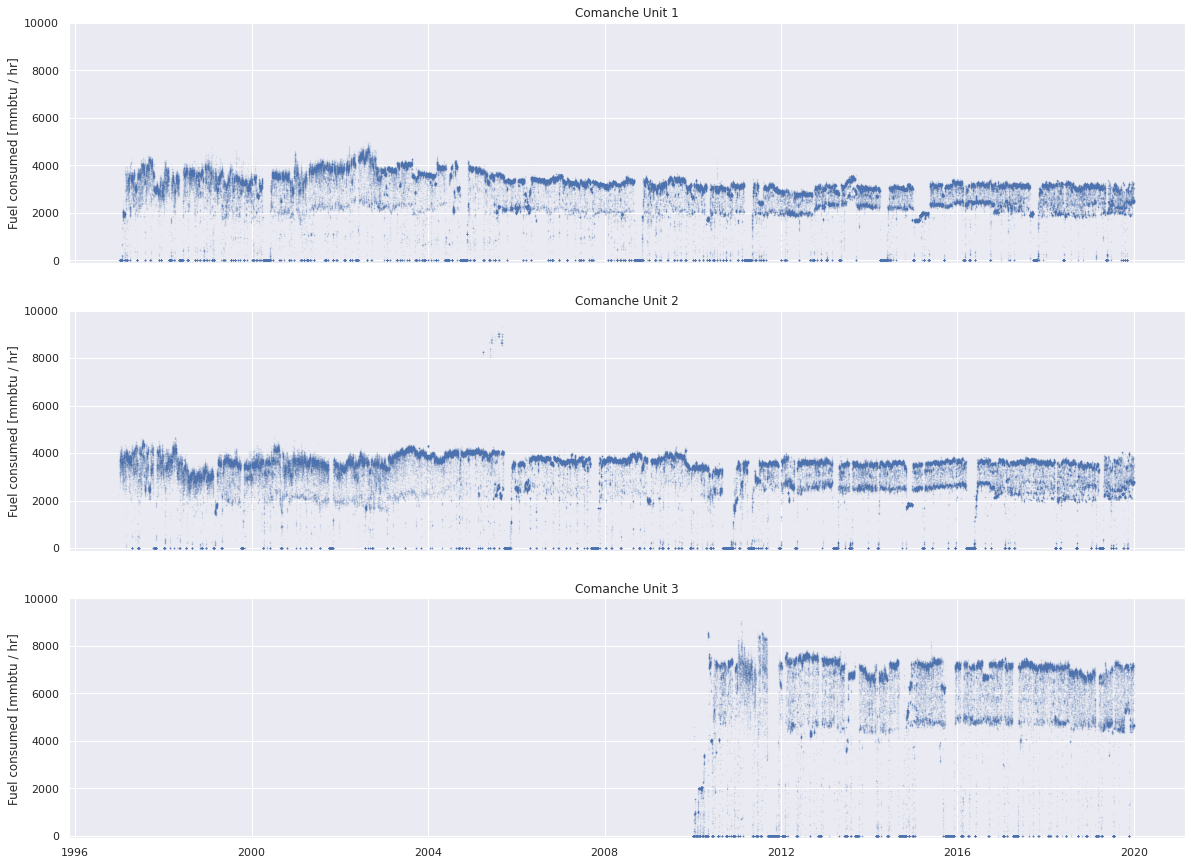

In [19]:
unit_ids = comanche_df.unitid.unique()
fig, axs = plt.subplots(nrows=len(unit_ids), ncols=1, sharex=True, figsize=(20,15))
for n, unitid in enumerate(comanche_df.unitid.unique()):
    axs[n].scatter(
        comanche_df.query("unitid==@unitid").operating_datetime_utc,
        comanche_df.query("unitid==@unitid").heat_content_mmbtu,
        s=0.2, alpha=0.1,
    )
    axs[n].set_ylim(-100,10_000)
    axs[n].set_title(f"Comanche Unit {unitid}")
    axs[n].set_ylabel("Fuel consumed [mmbtu / hr]")
plt.show();

### Heat Rate

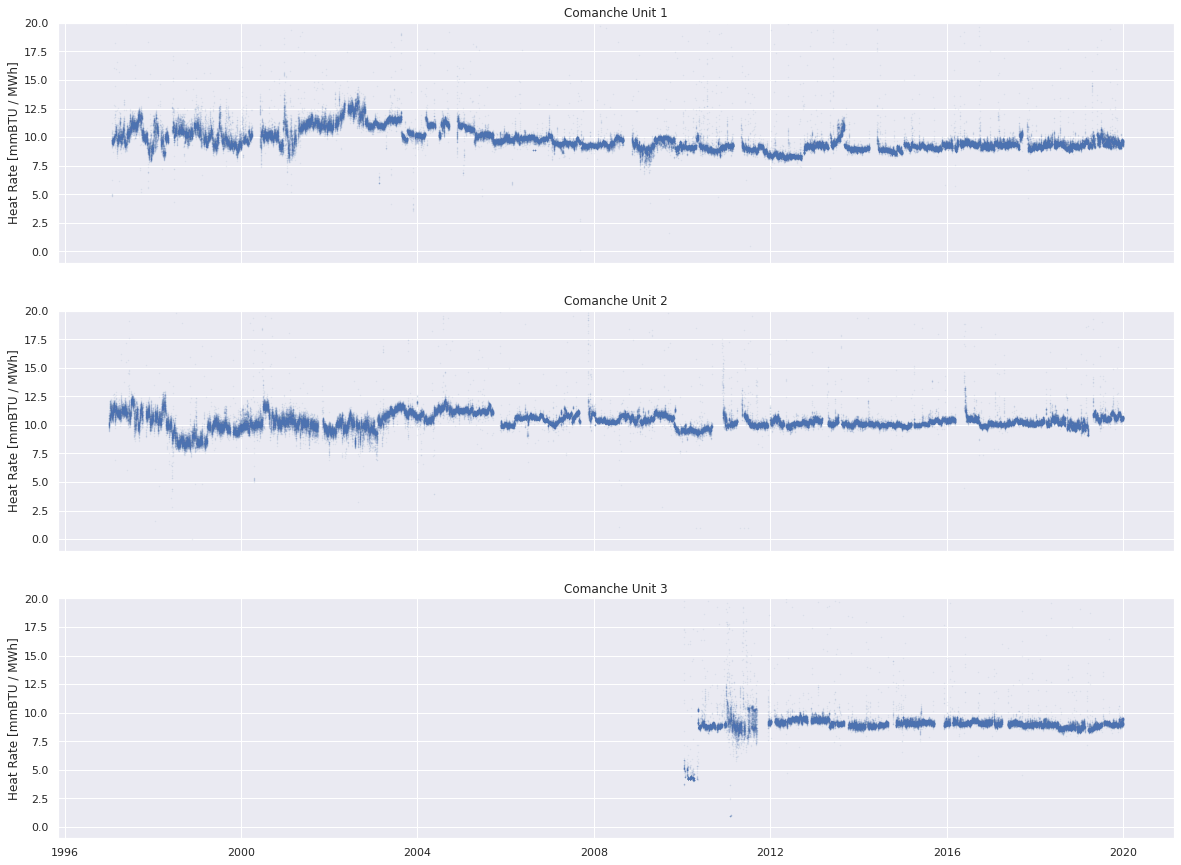

In [20]:
unit_ids = comanche_df.unitid.unique()
fig, axs = plt.subplots(nrows=len(unit_ids), ncols=1, sharex=True, figsize=(20,15))
for n, unitid in enumerate(comanche_df.unitid.unique()):
    axs[n].scatter(
        comanche_df.query("unitid==@unitid").operating_datetime_utc,
        comanche_df.query("unitid==@unitid").heat_rate_mmbtu_mwh,
        s=0.2, alpha=0.1,
    )
    axs[n].set_ylim(-1,20)
    axs[n].set_title(f"Comanche Unit {unitid}")
    axs[n].set_ylabel("Heat Rate [mmBTU / MWh]")
plt.show();

### Carbon Intensity

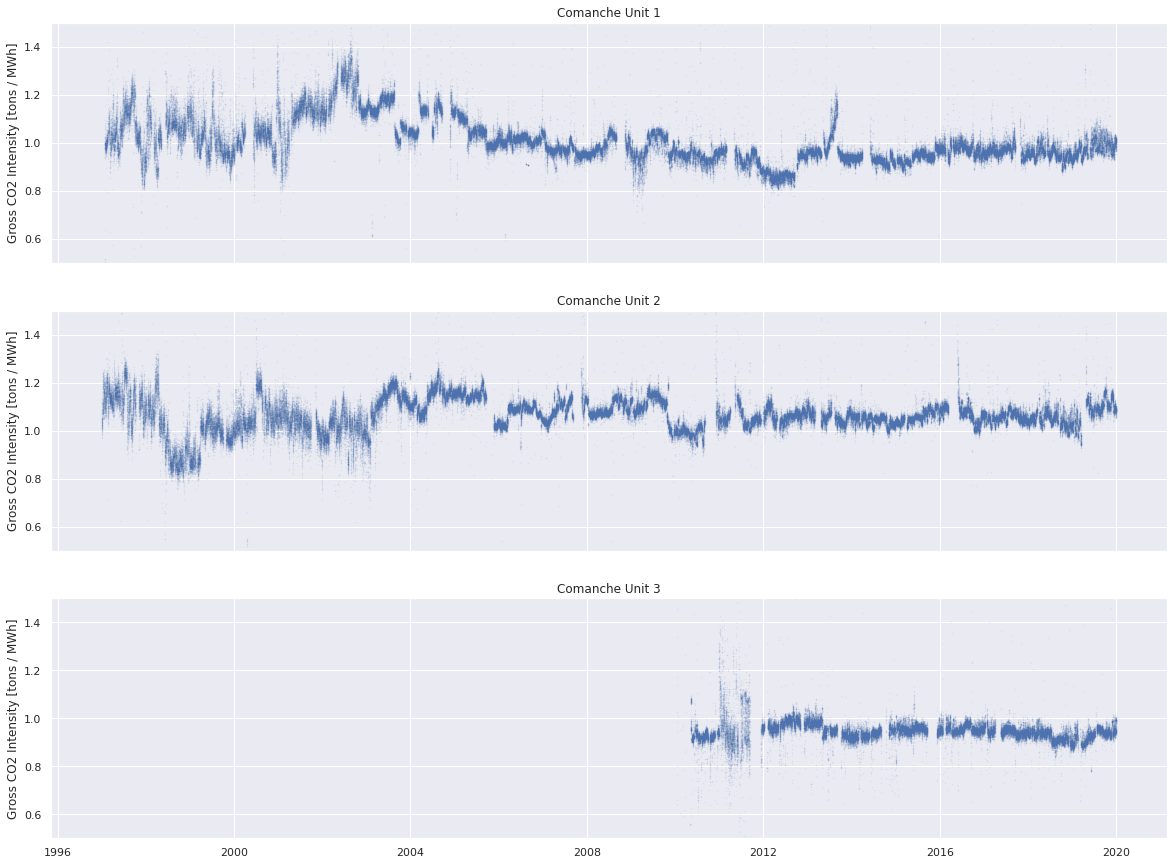

In [21]:
unit_ids = comanche_df.unitid.unique()
fig, axs = plt.subplots(nrows=len(unit_ids), ncols=1, sharex=True, figsize=(20,15))
for n, unitid in enumerate(comanche_df.unitid.unique()):
    axs[n].scatter(
        comanche_df.query("unitid==@unitid").operating_datetime_utc,
        comanche_df.query("unitid==@unitid").gross_co2_intensity,
        s=0.2, alpha=0.1,
    )
    axs[n].set_ylim(0.5,1.5)
    axs[n].set_title(f"Comanche Unit {unitid}")
    axs[n].set_ylabel("Gross CO2 Intensity [tons / MWh]")
plt.show();

### Gross Load

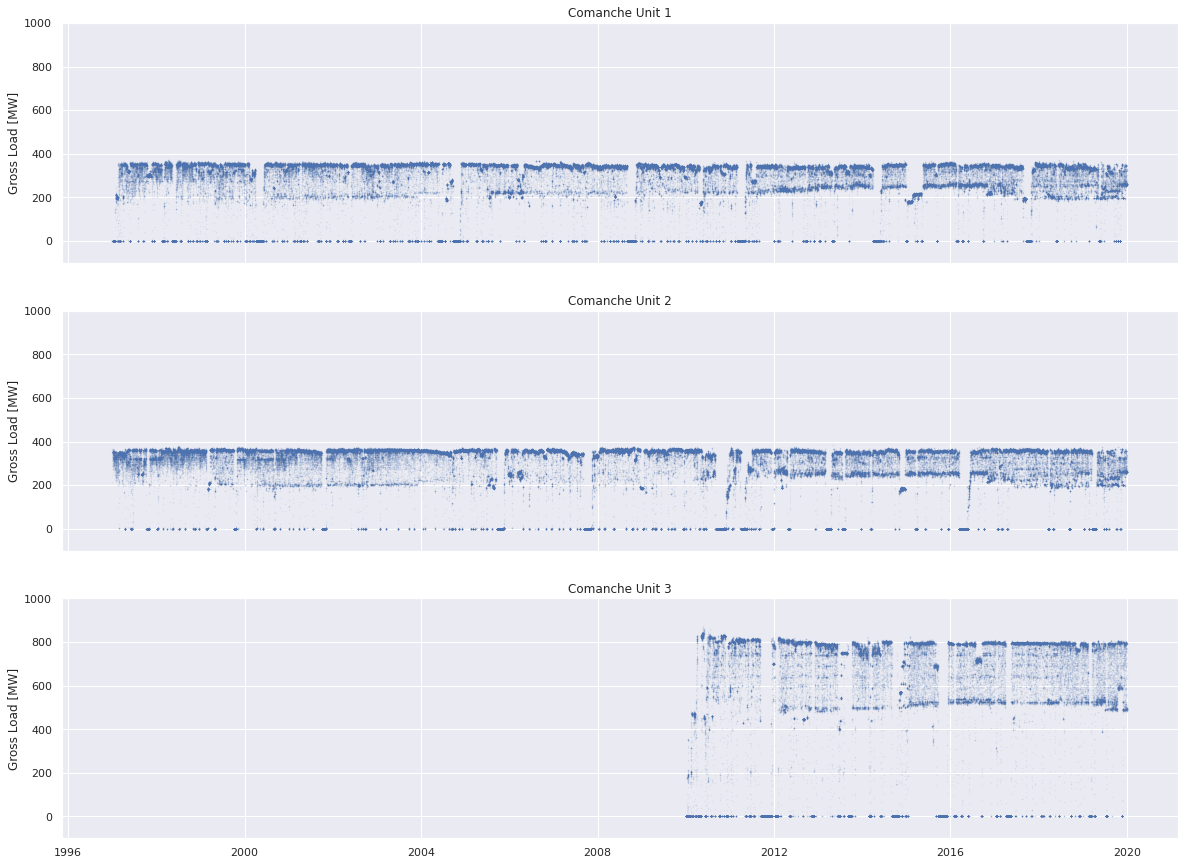

In [22]:
unit_ids = comanche_df.unitid.unique()
fig, axs = plt.subplots(nrows=len(unit_ids), ncols=1, sharex=True, figsize=(20,15))
for n, unitid in enumerate(comanche_df.unitid.unique()):
    axs[n].scatter(
        comanche_df.query("unitid==@unitid").operating_datetime_utc,
        comanche_df.query("unitid==@unitid").gross_load_mw,
        s=0.2, alpha=0.1,
    )
    axs[n].set_ylim(-100,1000)
    axs[n].set_title(f"Comanche Unit {unitid}")
    axs[n].set_ylabel("Gross Load [MW]")
plt.show();

# Aggregation and Data Reduction

Instead of selecting a small subset of a large dataset to investigate at its full resolution, you can also aggregate records to reduce large datasets to a managable size.

Now that you know what's available, pick the columns you'd like to work with, and aggregate rows if necessary. Note that the `state` and `measurement_code` columns are categorical datatypes, meaning that they will overwhile your computer's memory if included in the list of columns you'd like to groupby. In pandas, this is solved by including the statement `observed=True` in the groupby, but with Dask we'll solve this by changing the datatype to string. As mentioned previously, the dataset is very large. If the Dask dataframe you construct is too similar to the original dataset -- imagine the example below without the `groupby` -- the client will be unable to load it in pandas. The given dataset below should load in a couple of minutes.

In [23]:
%%time
# A list of the columns you'd like to include in your analysis
my_cols = [
    'year',
    'plant_id_eia', 
    'unitid',
    'so2_mass_lbs',
    'nox_mass_lbs',
    'co2_mass_tons'
]

# Select emissions data are grouped by state, plant_id and unit_id
# Remember to change the datatype for 'state' from category to string
my_cems_dd = (
    dd.read_parquet(epacems_path, columns=my_cols)
    .astype({
        'year': int,
    })
    .groupby(['year', 'plant_id_eia', 'unitid'])[[
        'so2_mass_lbs',
        'nox_mass_lbs',
        'co2_mass_tons'
    ]]
    .sum()
).reset_index()
cems_byunit = my_cems_dd.compute()

CPU times: user 8min 20s, sys: 27.5 s, total: 8min 48s
Wall time: 6min 5s


In [24]:
cems_byplant = cems_byunit.groupby(["plant_id_eia", "year"]).sum()

In [25]:
plants_df = (
    pudl_out.plants_eia860()
    .loc[:, ["plant_id_eia", "report_date", "plant_name_eia", "state", "longitude", "latitude" ]]
    .assign(year=lambda x: x.report_date.dt.year)
    .drop("report_date", axis="columns")
    .pipe(pudl.helpers.oob_to_nan, ["latitude"], lb=-90.0, ub=90.0)
    .pipe(pudl.helpers.oob_to_nan, ["longitude"], lb=-180.0, ub=180.0)
    .dropna()
    .query("state not in ('AK', 'HI')")
    .query("latitude < 50.0")
)

merged_cems_df = (
    plants_df.merge(
        cems_byplant,
        on=["year", "plant_id_eia"],
        how="inner",
    )
)

cems_gdf = (
    gpd.GeoDataFrame(
        merged_cems_df,
        geometry=gpd.points_from_xy(merged_cems_df.longitude, merged_cems_df.latitude),
        crs="EPSG:4326",  # Geographic coordinates: Latitude / Longitude in degrees.
    )
    .drop(["latitude", "longitude"], axis="columns")
    .to_crs("EPSG:3857")
)
cems_gdf.sample(10)

plant_id_eia               plant_name_eia state  year  so2_mass_lbs  \
4577           3096                Brunot Island    PA  2017  4.225380e+02   
163             113                       Cholla    AZ  2018  3.617204e+06   
14143         55853  Inland Empire Energy Center    CA  2012  1.447111e+04   
14122         55841                   Silverhawk    NV  2011  9.371143e+03   
1810           1077                   Sutherland    IA  2015  1.066138e+04   
5622           3947                       Kammer    WV  2013  2.115964e+07   
13438         55505                Frank Knutson    CO  2011  6.893880e+02   
12401         55270       Jackson Power Facility    MI  2019  1.041276e+04   
178             116                     Ocotillo    AZ  2014  5.868900e+02   
9826          50479   Georgia Pacific Big Island    VA  2009  0.000000e+00   

       nox_mass_lbs  co2_mass_tons                           geometry  
4577   2.106819e+04   4.184006e+04   POINT (-8910430.716 4933724.892)  
163    8.059916e+06   4.465726e+06  POINT (-12278907.189 4155648.893)  
14143  9.276980e+04   1.433276e+06  POINT (-13043345.813 3993788.161)  
14122  1.403292e+05   9.281343e+05  POINT (-12797355.453 4356880.085)  
1810   4.065927e+05   1.080925e+05  POINT (-10337066.021 5168072.337)  
5622   3.935174e+06   9.413828e+05   POINT (-8996685.399 4843603.089)  
13438  4.594779e+03   7.136210e+03  POINT (-11653148.605 4857390.991)  
12401  1.112188e+06   1.031182e+06   POINT (-9392771.279 5198321.645)  
178    1.410330e+05   5.812016e+04  POINT (-12458009.118 3951518.989)  
9826   2.177868e+05   0.000000e+00   POINT (-8833980.831 4513803.195)

<AxesSubplot:>

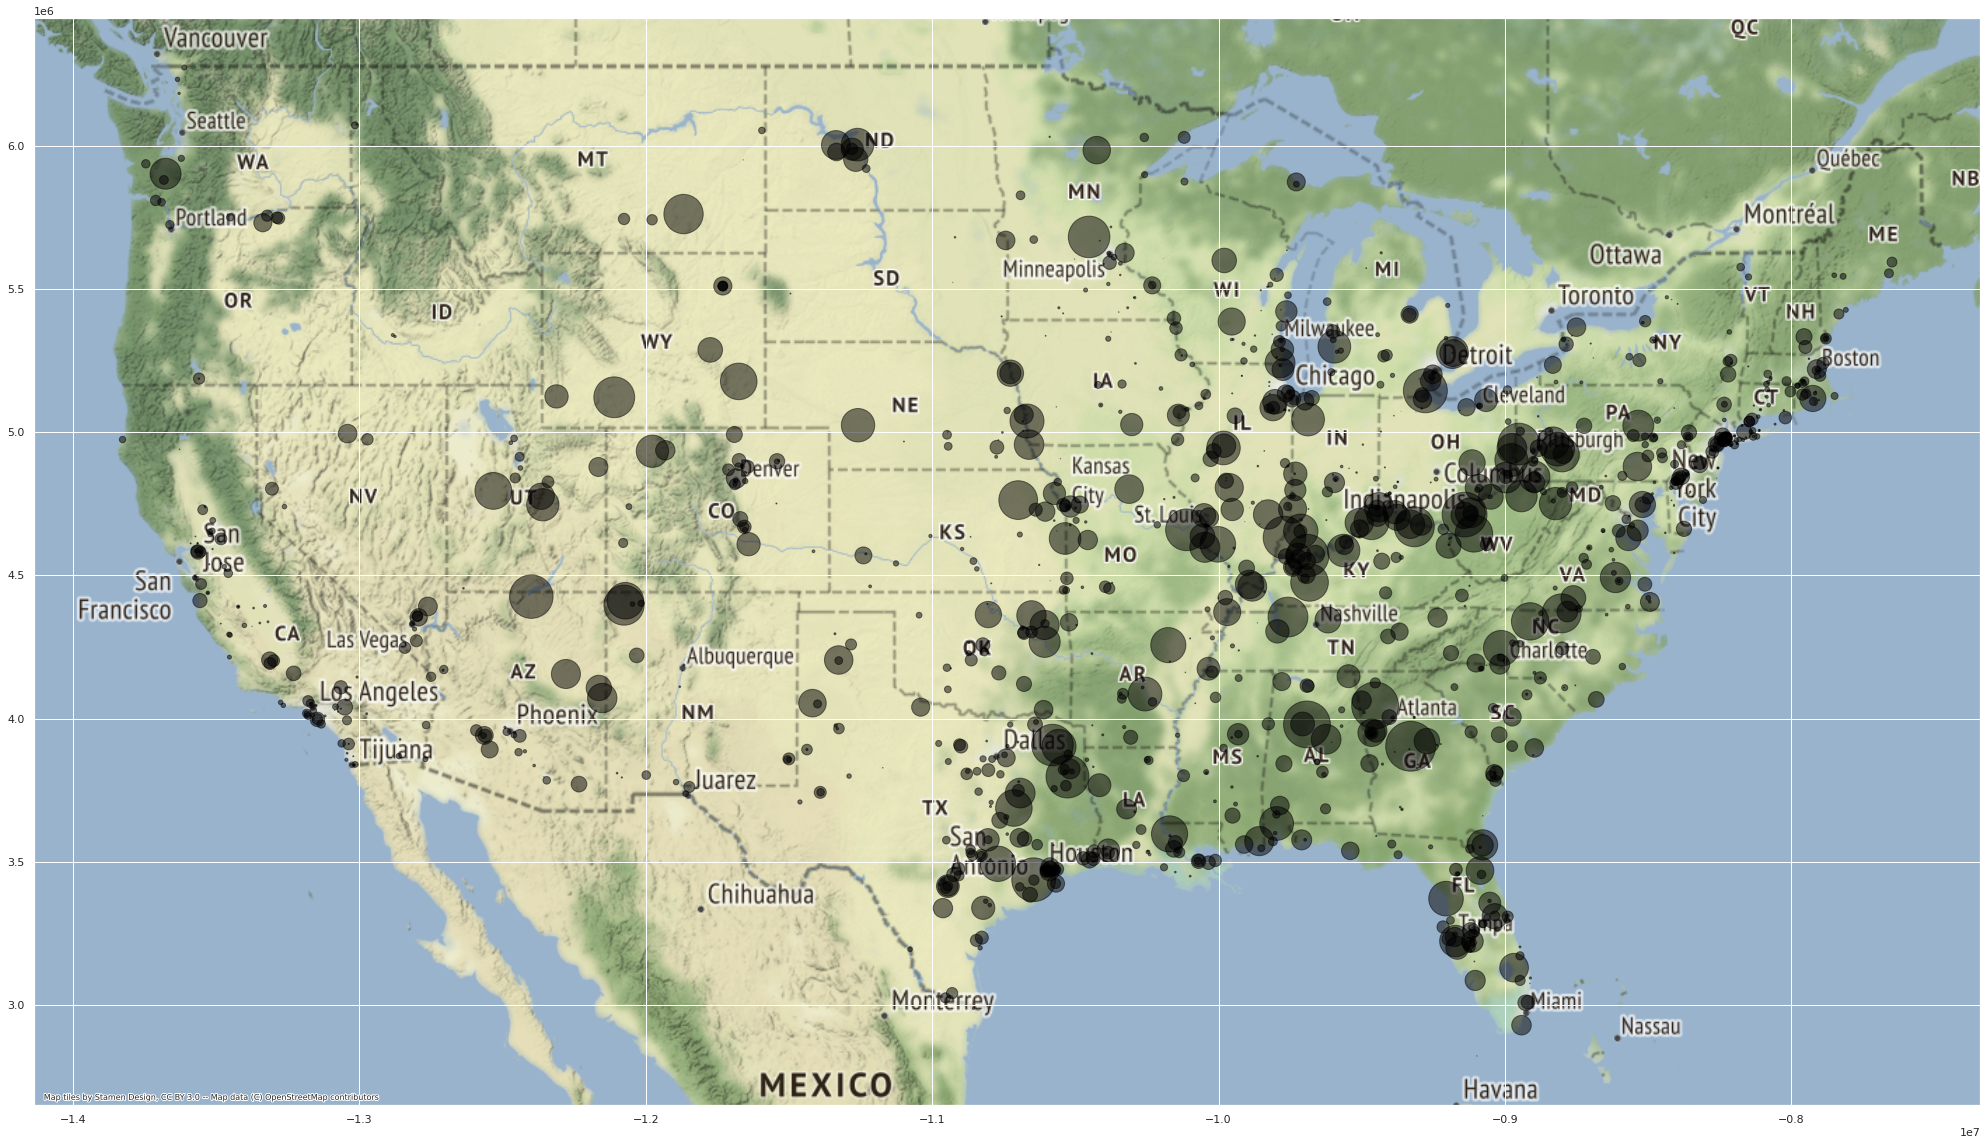

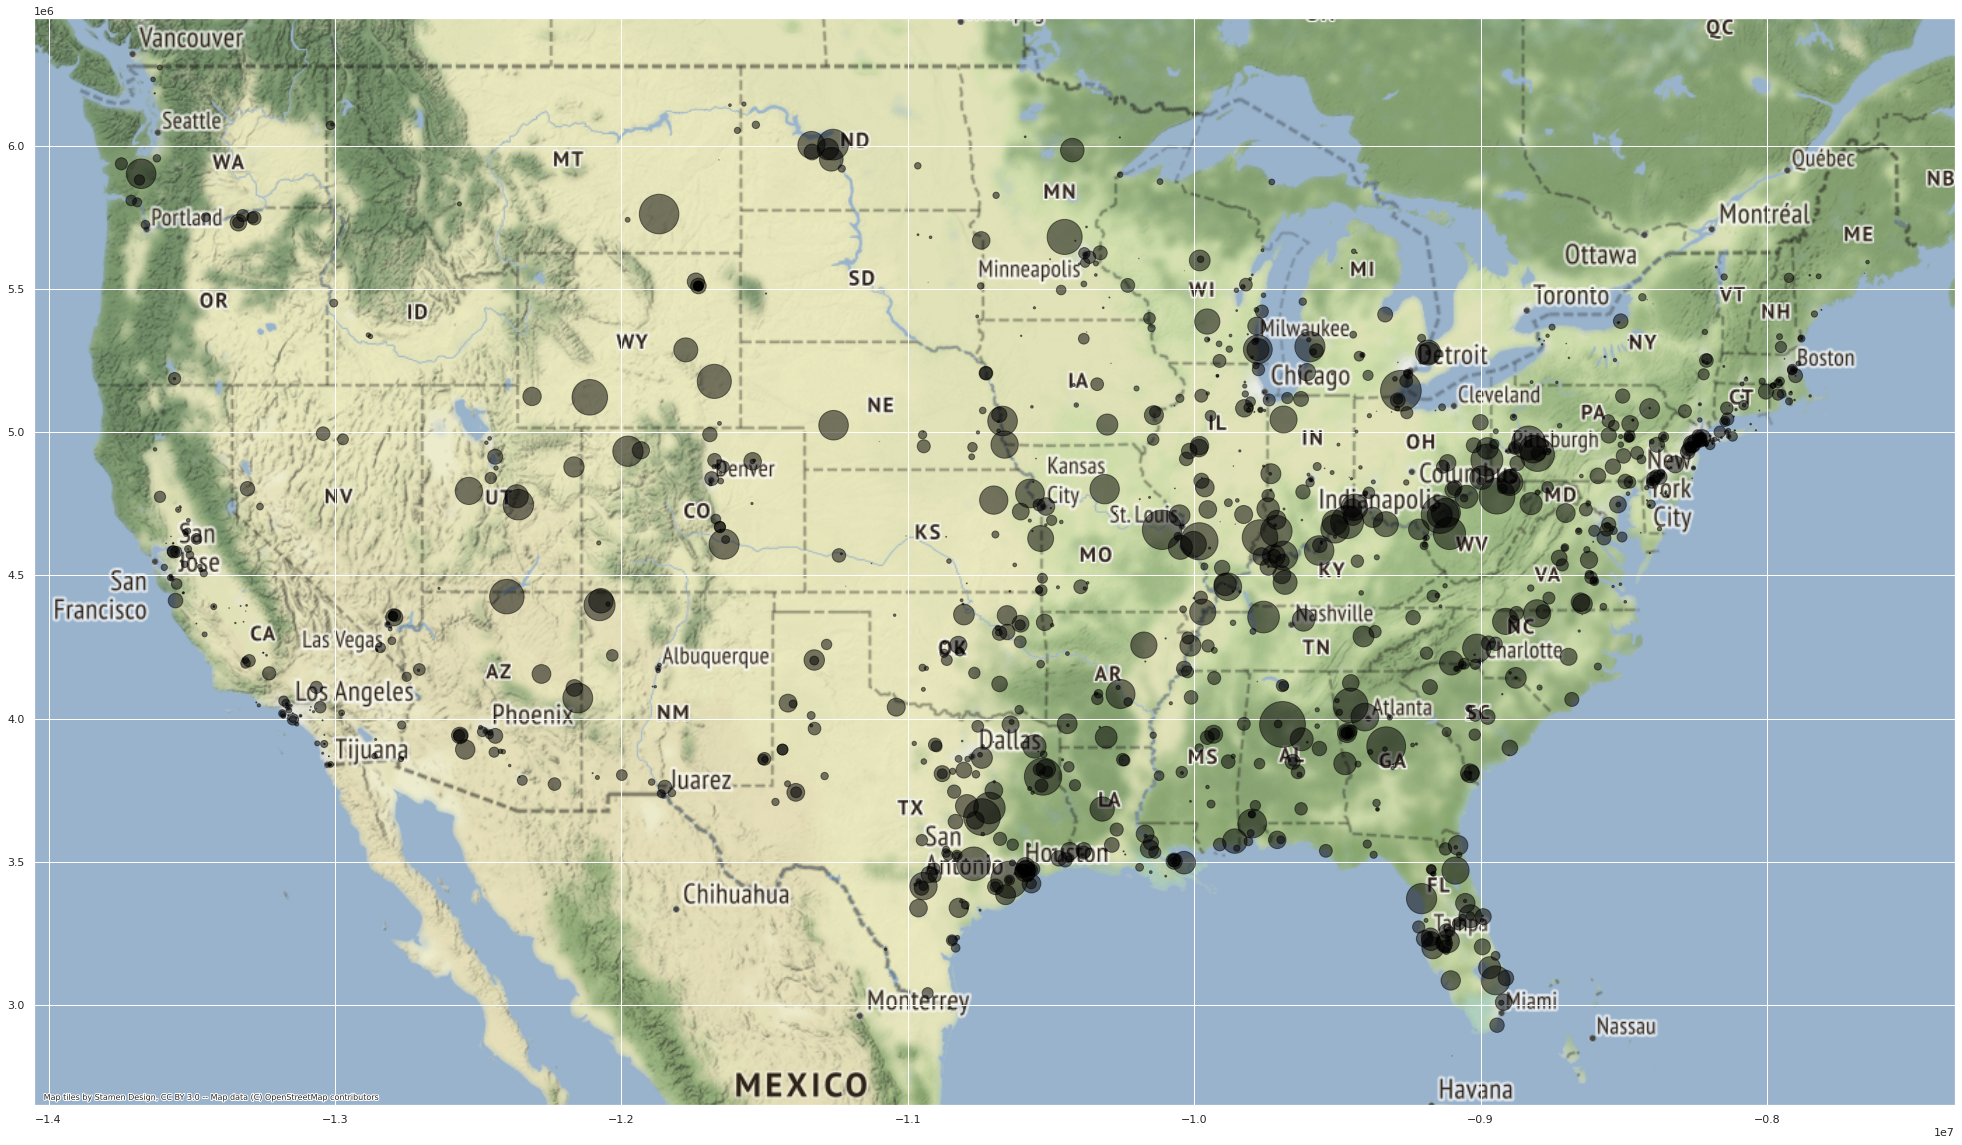

In [30]:
def map_point_source_emissions(gdf, year, states=None, scaling=1e4, alpha=0.25):
    import contextily as ctx
    gdf_to_plot = gdf.query("year==@year")
    if states is not None:
        gdf_to_plot = gdf_to_plot[gdf_to_plot.state.isin(states)]
        
    ax = gdf_to_plot.plot(
        figsize=(40,20),
        color="black",
        alpha=alpha,
        markersize=gdf_to_plot.co2_mass_tons / scaling,
    )
    ctx.add_basemap(ax)
    return ax

map_point_source_emissions(cems_gdf, 2009, states=None, scaling=1e4, alpha=0.5)
map_point_source_emissions(cems_gdf, 2019, states=None, scaling=1e4, alpha=0.5);

In [27]:
assert False

AssertionError: 

<a id='2transfer'></a>
#### 2. Transfer desired data to pandas

Now that you've selected the data you want to work with, we'll transfer it to pandas so that all rows are accessible. It'll take a moment to run because there are so many rows. If it takes longer than a couple of minutes, check to see that your Dask dataset is altered enough from it's original form. Remember, it's in Dask because the data is bigger than your computer's memory!

In [ ]:
# Create a pandas dataframe out of your Dask dataframe and add a column to 
# indicate the year the data are coming from.
client = Client()
my_cems_df = (
    client.compute(my_cems_dd)
    .result()
    .assign(year=year)
).reset_index()

In [ ]:
my_cems_df

**To get data from *multiple* years, run the following code:**

In [ ]:
years = range(2010, 2020)  # Edit date range at will
multi_year_cems_df = pd.DataFrame()

for yr in years:
    epacems_path = (pudl_settings['parquet_dir'] + f'/epacems/year={yr}')
    cems_dd = (
        dd.read_parquet(epacems_path, columns=my_cols)
        .assign(state=lambda x: x['state'].astype('string'))
        .groupby(['plant_id_eia', 'unitid', 'state'])[
            ['so2_mass_lbs', 'nox_mass_lbs', 'co2_mass_tons']]
        .sum())
    cems_df = (
        client.compute(cems_dd)
        .result()
        .assign(year=yr))
    multi_year_cems_df = pd.concat([multi_year_cems_df, cems_df])

In [ ]:
multi_year_cems_df

<a id='manipulating'></a>
## Manipulating & Visualizing CEMS data

Now that we have access to CEMS in pandas, lets see what we can do!

<a id='emap'></a>
### 1. Simple Choropleth
##### *Visualizing CEMS data*

Lets start by mapping which states have the highest CO2 emissions from power plants in 2018. States with darker colors indicate higher CO2 emissions. To do this, we'll need to merge a geodataframe of the US with the desired emissions data from each state.

##### Prep US geospatial data:

In [ ]:
# Use pre-existing pudl shapefile for state outlines
us_map_df = (
    pudl.analysis.service_territory.get_census2010_gdf(pudl_settings, 'state')
    .rename({'STUSPS10': 'state'}, axis=1)
    .to_crs("EPSG:3395")
)

##### Prep CEMS data:

In [ ]:
# Convert lbs to tons for so2 and nox and remove old columns
# Aggregate CEMS data to the state level
cems_map_df = (
    my_cems_df.assign(
        so2_mass_tons=lambda x: x.so2_mass_lbs * 0.0005,
        nox_mass_tons=lambda x: x.nox_mass_lbs * 0.0005
    ).drop(columns=['so2_mass_lbs', 'nox_mass_lbs', 'plant_id_eia'], axis=1)
    .groupby(['state', 'year']).sum(min_count=1)
    .reset_index()
)

##### Combine with Geo-data and Plot:

In [ ]:
# Combine CEMS and MAP dataframes
states_cems_gdf = pd.merge(us_map_df, cems_map_df, on='state', how='outer')

In [ ]:
states_cems_gdf[states_cems_gdf['state']=='AK']

In [ ]:
# Add plots for the US, HI, and AK

# The column on which to base the choroplath
choro_col = 'co2_mass_tons'

us_fig, us_ax = plt.subplots(figsize=(15, 10))
#ak_hi_fig, (ak_ax, hi_ax) = plt.subplots(ncols=2)

states_cems_gdf.plot(column=choro_col, cmap='Reds', linewidth=0.8, edgecolor='black', ax=us_ax)
#states_cems_gdf.plot(column=choro_col, cmap='Reds', linewidth=0.8, edgecolor='black', ax=ak_ax)
#states_cems_gdf.plot(column=choro_col, cmap='Reds', linewidth=0.8, edgecolor='black', ax=hi_ax)

us_ax.set_xlim(-1.45e7, -0.7e7) # Used to position US in center of the graph
us_ax.set_ylim(0.25e7, 0.65e7)  # Used to position US in center of the graph
us_ax.set_title('CO2 Emissions from Power Plants in 2018 (Megatons)', fontdict={'fontsize': '20'})
us_ax.axis('off')  # Remove lat and long tick marks
#ak_ax.set_xlim(1.9e7, 6.7e6)  #(-2e7, -1.4e7)
#ak_ax.set_ylim(0.6e7, 1.2e7)
#hi_ax.set_xlim(-1.71e7, -1.8e7)
#hi_ax.set_ylim(2e6, 2.6e6)

# Add a legend
vmax = states_cems_gdf[f'{choro_col}'].max() / 1000000 # (convert from tons to megatons)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=vmax))
sm._A = []
cbar = us_fig.colorbar(sm, orientation="horizontal", pad=0, aspect = 50)

<a id='pcem'></a>
### 2. Proportional Coordinates Map: *Biggest Polluters*
##### *Integrate CEMS with EIA plant location data*

In order to integreate CEMS with other datasets in pudl, you'll need to start by integrating CEMS with a dataset that also has a field for `plant_id_eia`. If you want to integrate with FERC later on, you'll also want a dataset that has a field for `plant_id_pudl`. Integrating with EIA860 data will also provide plant coordinates for a coordinate map.

##### Prep CEMS data:

In [ ]:
# Aggregate CEMS data to the plant level, adjust units for visualization purposes
cems_df = (
    my_cems_df
    .copy()
    .assign(
        co2_mass_mt=lambda df: df.co2_mass_tons / 10000 # measure in 10K tons
    ).drop(columns=['co2_mass_tons'], axis=1)
    .groupby(['plant_id_eia', 'state', 'year'])
    .sum(min_count=1)
    .reset_index()
)

##### Prep EIA data:

In [ ]:
# Grab EIA 860 plant data that matched the year selected for CEMS
plants_eia860 = (
    pudl_out.plants_eia860()
    .assign(year=lambda df: df.report_date.dt.year)
    .query("year==2018")
)

##### Combine EIA and CEMS data:

In [ ]:
# Combine CEMS and EIA on plant_id_eia, state, and year
eia860_cems_df = (
    pd.merge(plants_eia860, cems_df, on=['plant_id_eia', 'state', 'year'], how='inner')
)

##### Overlay Coordinates on Base Map:

In [ ]:
# Make lat and long data cols into plotable points in geopandas
# Make CRS compatile with base map
eia860_cems_gdf = (
    gpd.GeoDataFrame(
        eia860_cems_df, geometry=gpd.points_from_xy(
            eia860_cems_df.longitude, eia860_cems_df.latitude))
    .set_crs(epsg=4326, inplace=True) # necessary step before to_crs(epsg=3395)
    .to_crs(epsg=3395)
)

# Make a base map
us_fig, us_ax = plt.subplots(figsize=(15, 10))

base = us_map_df.plot(color='white', edgecolor='black', ax=us_ax)

us_ax.set_xlim(-1.45e7, -0.7e7) # Used to position US in center of the graph
us_ax.set_ylim(0.25e7, 0.65e7)  # Used to position US in center of the graph
us_ax.set_title('CO2 Emissions from Power Plants in 2018 (10K tons)', fontdict={'fontsize': '20'})
us_ax.axis('off')  # Remove lat and long tick marks

# Plot the coordinates on top of the base map
eia860_cems_df['alpha_co2'] = eia860_cems_df['co2_mass_mt'] 
eia860_cems_gdf.plot(ax=base, marker='o', color='red', markersize=eia860_cems_df['co2_mass_mt'], alpha=0.1)

<a id='glc'></a>
### 3. State-to-State Gross Load Comparison
##### *View the load profiles of given states*

Not all states use locally sourced electricity, however, looking at load profiles of plants per state can give you a glimpse of which states are responsible for the greatest fossil peak loads. This allocation can also be done by utility, but requires a table that maps plant or unit ownership percentage by utility.

##### Prep CEMS data (you'll have to re-load from Dask to get a new data arrangement):

In [ ]:
year = 2018

# A list of the columns you'd like to include in your analysis
my_cols = [
    'state',
    'plant_id_eia', 
    'unitid',
    'operating_datetime_utc',
    'co2_mass_tons',
    'gross_load_mw',
]

my_cems_dd = (
    dd.read_parquet(epacems_path, columns=my_cols)
    .assign(
        state=lambda x: x['state'].astype('string'),
        month=lambda x: x['operating_datetime_utc'].dt.month)
    .groupby(['state', 'month'])['gross_load_mw', 'co2_mass_tons'].sum()
    .reset_index()
)

# Create a pandas dataframe out of your Dask dataframe and add a column to 
# indicate the year the data are coming from.
client = Client()
my_cems_gl = (
    client.compute(my_cems_dd)
    .result()
)

In [ ]:
my_cems_gl['co2/load'] = my_cems_gl.co2_mass_tons / my_cems_gl.gross_load_mw

##### Select state subset:

In [ ]:
gl_piv = my_cems_gl.pivot(columns='state', index=['month'], values=['gross_load_mw'])
gl_piv_subset = load_piv.iloc[:, load_piv.columns.get_level_values(1).isin(
    ['CO', 'TX', 'WY', 'MN', 'OH', 'PA', 'WV', 'FL', 'GE', 'CA'])].copy()

##### Plot load comparison:

In [ ]:
load_piv_subset.plot(
    figsize=(15,8),
    title='CEMS Gross Load 2018',
    xticks=load_piv_subset.index,
)

##### Plot CO2 to gross load comparison:

In [ ]:
gl_piv = my_cems_gl.pivot(columns='state', index=['month'], values=['co2/load'])
gl_piv_subset = load_piv.iloc[:, load_piv.columns.get_level_values(1).isin(
    ['CO', 'TX', 'WY', 'MN', 'OH', 'PA', 'WV', 'FL', 'GE', 'CA'])].copy()

<a id='pcem'></a>
### 3. Value-based Heat Map
##### *Integrate CEMS with EIA plant location data*

In [ ]:
#eia860_cems_gdf

# us_fig, us_ax = plt.subplots(figsize=(15, 10))

# base = us_map_df.plot(color='white', edgecolor='black', ax=us_ax)

# us_ax.set_xlim(-1.45e7, -0.7e7) # Used to position US in center of the graph
# us_ax.set_ylim(0.25e7, 0.65e7)  # Used to position US in center of the graph
# us_ax.set_title('CO2 Emissions from Power Plants in 2018 (10K tons)', fontdict={'fontsize': '20'})
# us_ax.axis('off')  # Remove lat and long tick marks

# gplt.kdeplot(
#     eia860_cems_gdf['co2_mass_mt'],
#     cmap='Reds',
#     shade=True, shade_lowest=False,
#     clip=eia860_cems_gdf.geometry,
#     ax=base
# )

#gplt.ployplot(eia860_cems_gdf, ax=us_ax)

#https://residentmario.github.io/geoplot/gallery/plot_nyc_collision_factors.html
# based on number of coordinates not values.